## LLMs

In [1]:
from llama_index.llms.ollama import Ollama  

chat_model = Ollama(model="qwen2:7b", context_window=80000, request_timeout=300)


In [2]:
# res = chat_model.complete("Hey")
# res.raw["message"]["content"]
# res.__dict__

## Researcher: An Agent Workflow

Let's create an agent workflow that would: 
defintions  
     

In [3]:
from bs4 import BeautifulSoup

def extract_text_with_beautifulsoup(raw_html: str) -> str:
    """
    Extract clean text from raw HTML using BeautifulSoup.
    
    Args:
        raw_html (str): Raw HTML content
        
    Returns:
        str: Extracted clean text
    """
    soup = BeautifulSoup(raw_html, 'html.parser')
    
    # Remove script and style elements
    for script in soup(["script", "style", "nav", "footer", "header", "aside"]):
        script.decompose()
    
    # Get text and clean it up
    text = soup.get_text()
    
    # Clean up whitespace
    lines = (line.strip() for line in text.splitlines())
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    text = ' '.join(chunk for chunk in chunks if chunk)
    
    return text


In [21]:
from typing import TypedDict, Optional, Annotated
from datetime import datetime
import urllib

from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages

# import mlflow
# mlflow.set_experiment(experiment_name=datetime.now().isoformat())
# mlflow.set_tracking_uri('http://localhost:5000')
# mlflow.llama_index.autolog()

MAX_NUMBER_URL_SOURCES = 1 

class SearchState(TypedDict):
    # Query to research
    query: str 

    # Keep the interactions for ReAct (Reason - Act - Observe - Repeat) style agent 
    messages: Annotated[list[AnyMessage], add_messages]

    # Section of the blogpost
    sections: list[str]

    # Current section that is being written 
    section: str

    # List of relevant urls webpages (resources/references) to the query 
    web_urls: Optional[list[str]] 

    # Current url that is being dowloaded processed 
    url: Optional[str] 

    # Retrieved text from from the respective urls websources 
    text_sources: Optional[list[str]]  

    # Final output blogpost
    post: str

    # To give new search qeury for finding url for a section
    overwrite_url_query_section: str

def create_plan(state: SearchState):
    """
    Create an exectution plan for an agent. Must define what subsections a blogpost will have. 
    """
    query = state["query"]
    msgs = state["messages"]
    prompt = f"Based on the previous conversation: {msgs}; Create a list of subsection that a blogpost on this {query} topic must have. Just output a list of subsections so that it can be parsed in python format, [section_name_1, section_name_2,.. etc], do not out put new line charcters, nothing else, just plain list."
    res = chat_model.complete(prompt)

    state["messages"] += [AIMessage(content=res.raw["message"]["content"])]
    state["sections"] = res.raw["message"]["content"].strip()[1:-1].split(",")

    print("create_plan: ", state["sections"])

    return state

def check_plan(state: SearchState):
    human_feedback = input("Please provide your input, if any: ")
    if len(human_feedback) > 0: 
        state["messages"] += [HumanMessage(content=human_feedback)]
        return "iterate"
    else:
        return "proceed"

def start_section(state: SearchState):
    section = state["sections"][0]
    state["sections"] = state["sections"][1:]
    state["section"] = f"You are writting a section about {section} that is a part of the blogpost on {state['query']}" 
    print("Starting to process a section: ", state["section"])
    return state 

def give_feedback_url_webpages(state: SearchState):
    print("Are you fine with these links? - ", state["web_urls"])
    h_in = input()
    state["overwrite_url_query_section"] = h_in
    return state

def evaluate_url_webpages(state: SearchState): 
    if len(state["overwrite_url_query_section"]) > 0:
        return "iterate"
    else:
        return "proceed"

def get_relevant_webpages(state: SearchState):
    """
    Gets the url of the most relevant webpages for the query.

    Args:
        query (str): what to search online on www.

    Returns:
        str: url link.
    """
    from ddgs import DDGS

    search_ggg = DDGS()
    query_overwrite = state["overwrite_url_query_section"] if state["overwrite_url_query_section"] is not None else ""
    if (len(query_overwrite)>0):
        query_section =  state["overwrite_url_query_section"] 
    else: 
         query_section = state["section"]
    results = search_ggg.text(query=query_section, max_results=MAX_NUMBER_URL_SOURCES )
    state["web_urls"] += [res["href"] for res in results]

    print("get_relevant_webpages: ", state["web_urls"])
    
    return state

def download_webpages(state: SearchState) -> str:
    """
    Load the raw webpage of the url. Store it in the context.
    
    Args:
        url (str): www url of the page.
    
    Returns: 
        str: html string of the text on the webpage.
    """

    for url in state["web_urls"][-MAX_NUMBER_URL_SOURCES:]:
        try: 
            print(f"Will try to download this {url} webpage.")
            with urllib.request.urlopen(url) as response:
                html_text = response.read()
                state["text_sources"].append(extract_text_with_beautifulsoup(html_text))
        except urllib.error.URLError as e:
            print(f"Error getting the page {url}: ", e)
        except Exception as e:
            print(f"Something happened (for url {url}): ", e)
    
    return state

def generate_blogpost_section(state:SearchState) -> str:
    """
    Generate a blogpost section in the markdown format based on the raw of a resource. 
    """
    # TODO: how to use all the resources? 
    sources = state["text_sources"][-MAX_NUMBER_URL_SOURCES:]
    task = f"Based on the this information {sources}, generate a extensive blogpost section about the topic {state['section']} in the markdown format."
    print(f"Task: \n", task)
    res = chat_model.complete(task)
    state["post"] += res.raw["message"]["content"]

    return state

def do_another_section(state:SearchState):
    if len(state["sections"]) > 0: 
        return "proceed"
    else:
        return "stop"




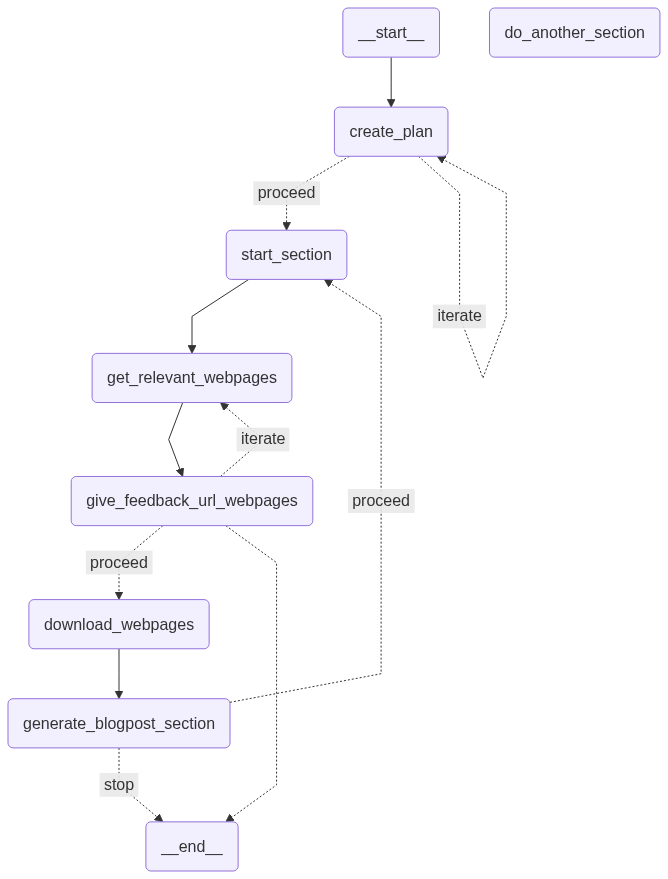

In [22]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Create the graph
researcher_graph = StateGraph(SearchState)

# Add nodes
researcher_graph.add_node("create_plan", create_plan)
researcher_graph.add_node("start_section", start_section)
researcher_graph.add_node("get_relevant_webpages", get_relevant_webpages)
researcher_graph.add_node("download_webpages", download_webpages)
researcher_graph.add_node("generate_blogpost_section", generate_blogpost_section)

researcher_graph.add_node("do_another_section", do_another_section)
researcher_graph.add_node("give_feedback_url_webpages", give_feedback_url_webpages)

researcher_graph.add_edge(START, "create_plan")
researcher_graph.add_conditional_edges(
    "create_plan",
    check_plan,
    {
        "proceed": "start_section",
        "iterate": "create_plan",
    }
)
researcher_graph.add_edge("start_section", "get_relevant_webpages")
researcher_graph.add_edge("get_relevant_webpages", "give_feedback_url_webpages")
researcher_graph.add_conditional_edges(
    "give_feedback_url_webpages",
    evaluate_url_webpages,
    {
        "proceed": "download_webpages",
        "iterate": "get_relevant_webpages",
    }
)

researcher_graph.add_edge("download_webpages", "generate_blogpost_section")
researcher_graph.add_conditional_edges(
    "generate_blogpost_section",
    do_another_section,
    {
        "proceed": "start_section",
        "stop": END,
    }
)
dag = researcher_graph.compile()
display(Image(dag.get_graph().draw_mermaid_png()))

In [24]:
init_state = SearchState(query="History of Prussia", text_sources=list(), web_urls=list(), post="", overwrite_url_query_section=None)
res = dag.invoke(init_state)

create_plan:  ["'Introduction to Prussia'", " 'Origins and Early History'", " 'Prussian Unification and Expansion'", " 'The Hohenzollern Dynasty'", " 'Key Figures in Prussian History'", " 'Influences on European Politics'", " 'World Wars and the Fall of Prussia'", " 'Legacy and Cultural Impact'"]
Starting to process a section:  You are writting a section about 'Introduction to Prussia' that is a part of the blogpost on History of Prussia
get_relevant_webpages:  ['https://en.wikipedia.org/wiki/Prussia']
Are you fine with these links? -  ['https://en.wikipedia.org/wiki/Prussia']
Will try to download this https://en.wikipedia.org/wiki/Prussia webpage.
Task: 
 Based on the this information ['Prussia - Wikipedia Jump to content From Wikipedia, the free encyclopedia European country, existing from 1525 to 1947 "Prussian" redirects here. For other uses, see Prussia (disambiguation). Not to be confused with Russia. PrussiaPreußen\xa0(German)Prūsija\xa0(Prussian)1525–1947[a] State flag(1803–189

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [ ]:
# import pprint
# # Set width to control line length (e.g., 80 characters)
# pp = pprint.PrettyPrinter(width=80, depth=4)
# pp.pprint(res)

NameError: name 'res' is not defined

In [ ]:
print(res["post"].text)
with open(f"post_v2_{datetime.now().strftime('%Y_%m_%d_%H_%M')}.md", "w") as f:
    f.write(res["post"].text)
